In [3]:
from EDA_script_original import *
# train_x_raw = pd.read_csv("../01-Data/X_train.csv", low_memory = True, index_col=0)
# train_y_raw = pd.read_csv("../01-Data/y_train.csv", low_memory = True, index_col=0)
# test_x_raw = pd.read_csv("../01-Data/X_test.csv", low_memory=True, index_col=0)

# df_train = pd.DataFrame(gitrain_x_raw)
# df_test = pd.DataFrame(test_x_raw)
# df_y = pd.DataFrame(train_y_raw)

# Simple Model Run
##  xgBoost model set up

In [4]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from bayes_opt import BayesianOptimization
from sklearn.metrics import log_loss
from matplotlib import pyplot
# Remap labels
label_mapping = {-1: 0, 1: 1, 2: 2, 3: 3, 4: 4}
df_y = df_y.replace(label_mapping)

## Bayesian Optimization

In [7]:
def xgb_cv_score(max_depth, gamma, colsample_bytree, subsample, eta, reg_lambda, reg_alpha, min_child_weight):
    """
    Computes the cross-validated log loss for given hyperparameter settings using Stratified K-Fold.
    """
    params = {
        'device': 'cuda',
        'max_depth': int(max_depth),
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'eta': eta,
        'objective': 'multi:softprob',
        'num_class': 5,
        'eval_metric': 'mlogloss',
        'lambda': reg_lambda,
        'alpha': reg_alpha,
        'min_child_weight': min_child_weight,
        'verbosity': 0,
        'seed': 42
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_loss_scores = []

    for train_index, test_index in skf.split(df_train, df_y):
        xgb_train = xgb.DMatrix(df_train.iloc[train_index], label=df_y.iloc[train_index])
        xgb_valid = xgb.DMatrix(df_train.iloc[test_index], label=df_y.iloc[test_index])
        
        watchlist = [(xgb_train, 'train'), (xgb_valid, 'eval')]

        # Add early_stopping_rounds
        model = xgb.train(params, xgb_train, num_boost_round=500, evals=watchlist, early_stopping_rounds=10, verbose_eval=False)

        # Predict using the best iteration
        preds = model.predict(xgb_valid)
        #preds = model.predict(xgb_valid, ntree_limit=(model.best_iteration + 1) * params['num_class']

        log_loss_score = log_loss(df_y.iloc[test_index], preds, labels=list(range(5)))
        log_loss_scores.append(log_loss_score)

    return -np.mean(log_loss_scores)

# Define the hyperparameter bounds
pbounds = {
    'max_depth': (3, 7),  # Reduced upper limit to prevent overfitting and reduce complexity.
    'gamma': (0.1, 4),  # Expanded to include lower values, allowing for less aggressive regularization at the low end.
    'colsample_bytree': (0.5, 0.8),  # Narrowed to focus on moderately high feature sampling for balance between performance and overfitting.
    'subsample': (0.5, 0.8),  # Similar to colsample_bytree, aiming for a balance in sampling.
    'eta': (0.01, 0.2),  # Narrowed upper limit to focus on more stable, albeit potentially slower, learning rates.
    'reg_lambda': (0.5, 4),  # Expanded lower bound to allow for less regularization, adjusted upper limit to prevent overly strong L2 regularization.
    'reg_alpha': (0, 0.5),  # Reduced upper limit to focus on lower levels of L1 regularization, preventing sparsity from being too aggressive.
    'min_child_weight': (1, 5),  # Narrowed to prevent overly conservative model by avoiding too large values.
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_cv_score, pbounds=pbounds, random_state=42, verbose=2)
optimizer.maximize(init_points=10, n_iter=30)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -0.8494   | 0.6124    | 0.1906    | 2.955     | 5.395     | 1.624     | 0.078     | 0.7033    | 0.7599    |


KeyboardInterrupt: 

## CV xgboost train with best parameters

In [ ]:
optimizer.max['params']

{'colsample_bytree': 0.5210431389446492,
 'eta': 0.039005806342157376,
 'gamma': 0.45710421341765506,
 'max_depth': 6.976113043780855,
 'min_child_weight': 2.2353161758691513,
 'reg_alpha': 0.0022402427941256575,
 'reg_lambda': 1.897970798384294,
 'subsample': 0.7271446530822868}

In [8]:
optimizer.max['params'] = {'colsample_bytree': 0.5210431389446492,
 'eta': 0.039005806342157376,
 'gamma': 0.45710421341765506,
 'max_depth': 6.976113043780855,
 'min_child_weight': 2.2353161758691513,
 'reg_alpha': 0.0022402427941256575,
 'reg_lambda': 1.897970798384294,
 'subsample': 0.7271446530822868}
X_train, X_val, y_train, y_val = train_test_split(df_train, df_y, test_size=0.3, random_state=42)

# Best parameters from optimization
best_params = {
    'max_depth': int(optimizer.max['params']['max_depth']),
    'gamma': 3,
    'colsample_bytree': optimizer.max['params']['colsample_bytree'],
    'subsample': optimizer.max['params']['subsample'],
    'eta': optimizer.max['params']['eta'],
    'lambda': optimizer.max['params']['reg_lambda'],
    'alpha': optimizer.max['params']['reg_alpha'],
    'min_child_weight': optimizer.max['params']['min_child_weight'],
    'objective': 'multi:softprob',
    'num_class': 5,
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

[0]	train-mlogloss:1.47589	val-mlogloss:1.47948
[1]	train-mlogloss:1.36940	val-mlogloss:1.37639
[2]	train-mlogloss:1.29123	val-mlogloss:1.30160
[3]	train-mlogloss:1.22558	val-mlogloss:1.23844
[4]	train-mlogloss:1.17026	val-mlogloss:1.18587
[5]	train-mlogloss:1.12671	val-mlogloss:1.14489
[6]	train-mlogloss:1.08942	val-mlogloss:1.10943
[7]	train-mlogloss:1.05682	val-mlogloss:1.07875
[8]	train-mlogloss:1.03094	val-mlogloss:1.05509
[9]	train-mlogloss:1.00714	val-mlogloss:1.03385
[10]	train-mlogloss:0.98499	val-mlogloss:1.01362
[11]	train-mlogloss:0.96701	val-mlogloss:0.99780
[12]	train-mlogloss:0.94976	val-mlogloss:0.98239
[13]	train-mlogloss:0.93469	val-mlogloss:0.96967
[14]	train-mlogloss:0.92151	val-mlogloss:0.95875
[15]	train-mlogloss:0.90927	val-mlogloss:0.94902
[16]	train-mlogloss:0.89869	val-mlogloss:0.94075
[17]	train-mlogloss:0.88844	val-mlogloss:0.93290
[18]	train-mlogloss:0.87928	val-mlogloss:0.92627
[19]	train-mlogloss:0.87105	val-mlogloss:0.92090
[20]	train-mlogloss:0.86326	va

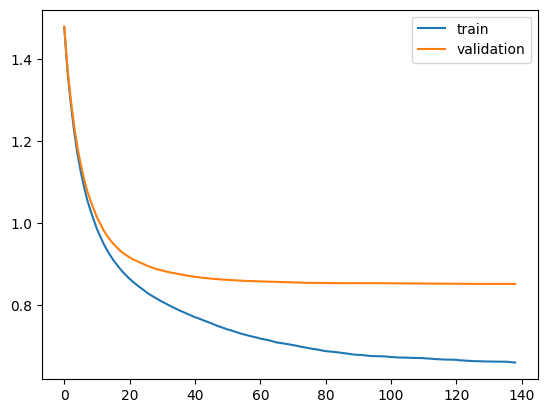

Training Multiclass Logarithmic Loss: 0.6590787919990474
Validation Multiclass Logarithmic Loss: 0.8509143164018557


In [11]:
evals_result = {}
bst = xgb.train(best_params, dtrain, num_boost_round=1000, evals=[(dtrain, 'train'), (dval, 'val')],
                early_stopping_rounds=10, evals_result=evals_result, verbose_eval=True)

# Evaluate and print the final training and validation loss
train_last_eval = evals_result['train']['mlogloss'][-1]
val_last_eval = evals_result['val']['mlogloss'][-1]

pyplot.plot(evals_result['train']['mlogloss'], label='train')
pyplot.plot(evals_result['val']['mlogloss'], label='validation')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

print(f"Training Multiclass Logarithmic Loss: {train_last_eval}")
print(f"Validation Multiclass Logarithmic Loss: {val_last_eval}")

## Generate Submission csv

In [6]:
# Combine X_train and X_val, and y_train and y_val
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

dfull = xgb.DMatrix(X_full, label=y_full)

# Retrain the model
evals_result_full = {}
bst_full = xgb.train(best_params, dfull, num_boost_round=1000, evals=[(dfull, 'full')],
                     early_stopping_rounds=10, evals_result=evals_result_full, verbose_eval=True)

train_full_last_eval = evals_result_full['full']['mlogloss'][-1]
print(f"Full Training Multiclass Logarithmic Loss: {train_full_last_eval}")

[0]	full-mlogloss:1.58103
[1]	full-mlogloss:1.55335
[2]	full-mlogloss:1.52789
[3]	full-mlogloss:1.50295
[4]	full-mlogloss:1.47851
[5]	full-mlogloss:1.45594
[6]	full-mlogloss:1.43429
[7]	full-mlogloss:1.41446
[8]	full-mlogloss:1.39579
[9]	full-mlogloss:1.37643
[10]	full-mlogloss:1.35775
[11]	full-mlogloss:1.34089
[12]	full-mlogloss:1.32382
[13]	full-mlogloss:1.30782
[14]	full-mlogloss:1.29205
[15]	full-mlogloss:1.27745
[16]	full-mlogloss:1.26287
[17]	full-mlogloss:1.24859
[18]	full-mlogloss:1.23626
[19]	full-mlogloss:1.22383
[20]	full-mlogloss:1.21214
[21]	full-mlogloss:1.20115
[22]	full-mlogloss:1.18997
[23]	full-mlogloss:1.17938
[24]	full-mlogloss:1.16879
[25]	full-mlogloss:1.15803
[26]	full-mlogloss:1.14765
[27]	full-mlogloss:1.13759
[28]	full-mlogloss:1.12858
[29]	full-mlogloss:1.12013
[30]	full-mlogloss:1.11193
[31]	full-mlogloss:1.10402
[32]	full-mlogloss:1.09574
[33]	full-mlogloss:1.08810
[34]	full-mlogloss:1.08097
[35]	full-mlogloss:1.07360
[36]	full-mlogloss:1.06630
[37]	full-m

In [9]:
dtest = xgb.DMatrix(df_test)
y_test_probs = bst_full.predict(dtest)
class_order = [0, 1, 2, 3, 4]
class_mapping = {class_label: f"Class{class_label}" for class_label in class_order}

submission_df = pd.DataFrame(y_test_probs, columns=class_mapping.values())
submission_df.columns = ['no answer', 'very important', 'quite important', 'not important', 'not at all important']
submission_df.insert(0, 'id', df_test.index)

# Save the submission file
submission_file = ('eda_script_og_amy2.csv')
submission_df.to_csv(submission_file, index=False)